# Cross-validated regularization

The goal of this demo is to determine the regularization parameter in a regression problem using cross-validation. We will be using the same example as in the class slides, to get an easy comparison with the bias/variance/noise results.

In [1]:
# A few imports. If you get a warning, it is coming from `mdp`, which is
# automatically wrapping the sklearn algorithms, including a deprecated one.
import numpy as np
import mdp
from scipy import stats
from sklearn import linear_model, cross_validation
import matplotlib.pyplot as plt

/Users/pberkes/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/pls.py:7: DeprecationWarning: This module has been moved to cross_decomposition and will be removed in 0.16
  "removed in 0.16", DeprecationWarning)


In [2]:
# Make plots prettier.
%matplotlib inline

# Customize all matplotlib plots
font = {'size': 18}
plt.rc('font', **font)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [3]:
# Fix random seed to make notebook results reproducible.
np.random.seed(74666)

We will try to approximate the function sin(x) using 100 Radial Basis Functions as our regression basis. We distribute the centers evenly between -3 and 3, and make the radius very narrow. The example is a bit extreme, to make some effects like overfitting more obvious.

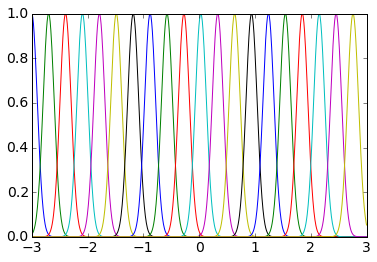

In [4]:
# Create the Radial Basis Functions.
M = 100

centers = np.linspace(-3, 3, M)
sizes = np.ones(M) * 0.01
rbf = mdp.nodes.RBFExpansionNode(centers[:, None], sizes)

# Plot every 5th RBFs
x = np.linspace(-3, 3, 1000)
_ = plt.plot(x, rbf(x[:, None])[:,::5], lw=1)

In [5]:
# Create the data set.

# Input data set.
x = np.linspace(-3, 3, 500)
# Target data set. We add some noise to make life interesting.
t = np.sin(x) + stats.norm.rvs(loc=0, scale=0.1, size=x.shape)

# This is the output of the basis functions, phi_j(x)
phi_x = rbf(x[:, None])

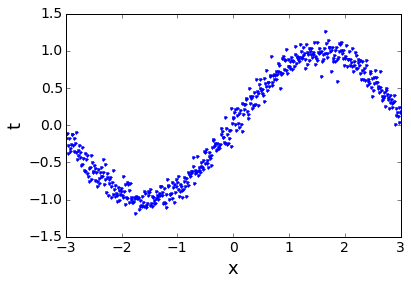

In [6]:
# Plot the data set.
_ = plt.plot(x, t, '.')
plt.xlabel('x')
plt.ylabel('t')

## A first cross-validation attempt, using KFold

In [7]:
# We want to find the optimal regularization parameter, alpha.

# These are the alphas that we're going to consider.
alphas = np.logspace(-2, 1., 50)

all_scores = []

for alpha in alphas:
    # Create the linear regression object.
    lm = linear_model.Ridge(alpha=alpha)
    
    # Run cross validation using K folds, and MSE as score.
    K = 4
    scores = - cross_validation.cross_val_score(lm, phi_x, t, cv=K, 
                                                scoring='mean_squared_error')

    # Collect the scores for each fold.
    all_scores.append(scores)

all_scores = np.array(all_scores)

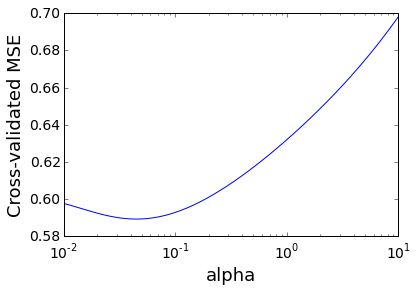

In [8]:
# Plot the mean score as a function of alpha.
mean_scores = all_scores.mean(axis=1)
plt.plot(alphas, mean_scores)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Cross-validated MSE')

In [9]:
# Find the optimal value of alpha
opt_idx = mean_scores.argmin()
opt_alpha = alphas[opt_idx]
print 'Optimal alpha is', opt_alpha

Optimal alpha is 0.0471486636346


We're done... or are we?

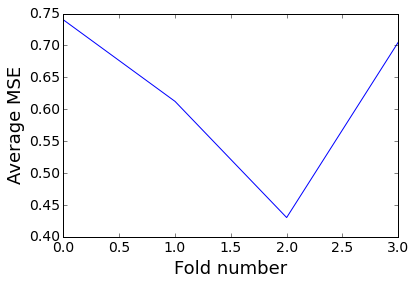

In [10]:
plt.plot(all_scores.mean(0))
plt.xlabel('Fold number')
plt.ylabel('Average MSE')

The score is very much dependent on the fold number! Also, the MSE values that we get are far higher than the one estimated in the class slides.
Something is wrong...

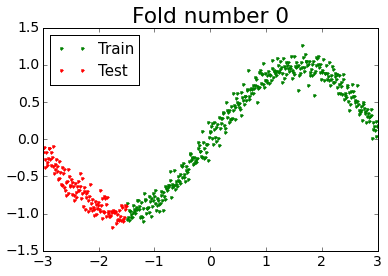

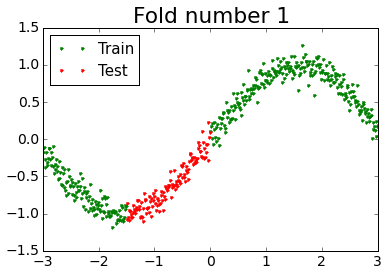

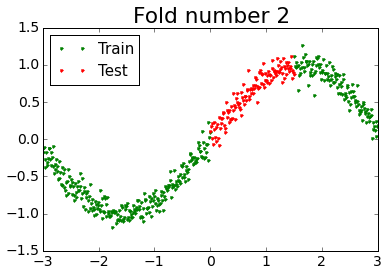

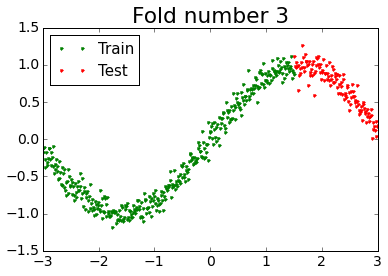

In [11]:
# Let's look at what parts of our data is the training and test set
cv = cross_validation.KFold(len(t), n_folds=K)
for plot_idx, (train_idx, test_idx) in enumerate(cv):
    plt.plot(x[train_idx], t[train_idx], 'g.')
    plt.plot(x[test_idx], t[test_idx], 'r.')
    plt.legend(['Train', 'Test'], fontsize='small', loc=2)
    plt.title('Fold number {}'.format(plot_idx))
    plt.show()

The training and test data sets are completely disjoint. The training data does not give any useful information about the coefficients of the RBFs in the test region.

One option would be to shuffle the data before running CV. Another is to use a CV method that does not select contiguous chunks of data.

In [12]:
# Run the experiment again, this time using a ShuffleSplit with the same
# number of iterations and test data size.

cv = cross_validation.ShuffleSplit(len(t), n_iter=4, test_size=0.25)

all_scores = []

for alpha in alphas:
    lm = linear_model.Ridge(alpha=alpha)
    scores = - cross_validation.cross_val_score(lm, phi_x, t, cv=cv, 
                                                scoring='mean_squared_error')
    all_scores.append(scores)

all_scores = np.array(all_scores)

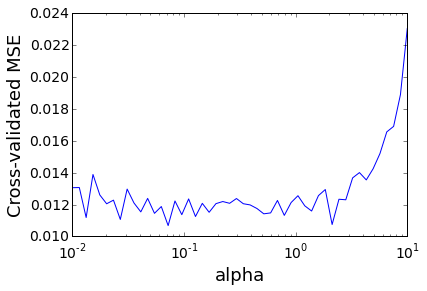

In [13]:
# Plot the mean score as a function of alpha.
mean_scores = all_scores.mean(axis=1)
plt.plot(alphas, mean_scores)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Cross-validated MSE')

This time the values are fine... but why are we getting noisier results, even if we're using the same number of folds and the same test set size?

The problem is that for each alpha we're using slightly different partitions.

In [14]:
# Run the experiment again, fixing the initial random seed for the
# cross-validator.

cv = cross_validation.ShuffleSplit(len(t), n_iter=4, test_size=0.25,
                                   random_state=5253)

all_scores = []

for alpha in alphas:
    lm = linear_model.Ridge(alpha=alpha)
    scores = - cross_validation.cross_val_score(lm, phi_x, t, cv=cv, 
                                                scoring='mean_squared_error')
    all_scores.append(scores)

all_scores = np.array(all_scores)

Optimal alpha is 0.518


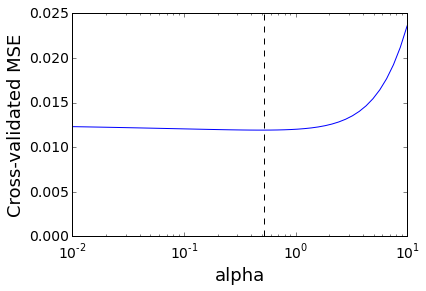

In [15]:
# Plot the mean score as a function of alpha.
mean_scores = all_scores.mean(axis=1)
plt.plot(alphas, mean_scores)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Cross-validated MSE')
plt.ylim([0, 0.025])

# Find the optimal value of alpha
opt_idx = mean_scores.argmin()
opt_alpha = alphas[opt_idx]
print 'Optimal alpha is', round(opt_alpha, 3)

plt.plot([opt_alpha, opt_alpha], [0, 0.025], 'k--')

Finally! Even better would have been to use a very large numer of folds, but that can quickly become very costly.

Note that in a more realistic setting, we should have reserved part of the data set to do a final fitting of the parameters using the optimal value of alpha.